# Lecture 6 - Image Segmentation Part 2

In this notebook, we will discuss additional methods on how we can segment objects of interest in our image. Specifically, we will discuss:
1. Chromaticity Segmentation
1. Image Differencing

The contents of this notebook is compiled from the following references:

- C Alis,*"Introduction to Digital Image"*, IIP 2018

Organized by:
Benjur Emmanuel L. Borja

---

The segmentation methods we discussed in the last notebook relied on using a threshold to segment our image using the grayscale, RGB, and HSV color channels. However, there are some cases when we would need to segment our image using colors that are not obvious, e.g. skin color. For those cases, we will instead look at the RG Chromaticity space to mask our image.

## 1. Chromaticity Segmentation
**Chromaticity segmentation** relies on the RG Chromaticity space, a two-dimensional representation of color that removes information regarding the intensity value of our colors. We are looking at the proportion of our the difference color channels and map it using the normalized RGB space. To compute for the RG Chromaticity of an image, we use tha following equations:
<img src="eq.PNG" alt="equations" width="200"/>

To illustrate:
<img src="rg_chrom.png" alt="RG-Chromaticity" width="400"/>

We notice that the axes of the space are only the red and green channels (as the name implies) this ties back to the mathematical basis of RG chromaticity in that the ratios of the RGB colours can all be summed to 1.  In this way, we only need two values to obtain the complete 'colour identity'.

Let's try segmenting our image using this.

### 1.1 Parametric Segmentation
We first need to compute for the RG Chromaticity of our image. For this process, first we start with a colour reference patch for the object we wish to segment. We then obtain the signature of this patch on the red and green channels.  Following this we calculate the mean and standard deviation of the colours in the patch per colour channel, which we then use to obtain a gaussian distribution of our colours in the patch.  The intersection of the two gaussians (red and green) create the probability distribution of the colours of our complete image segment.  Finally, we threshold this probability distribution to create the mask that will segment the original image.

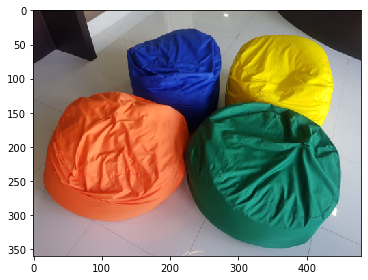

In [2]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import numpy as np


bags = imread('bags.png')
imshow(bags)

We use our equations to compute for the RG Chromaticity: 

(0.0, 1.0)

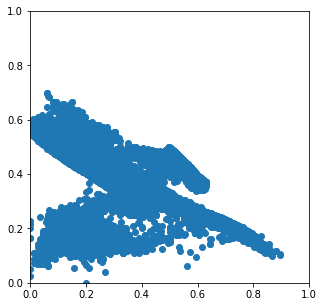

In [3]:
bags_R = bags[:,:,0]*1.0/bags.sum(axis=2)
bags_G = bags[:,:,1]*1.0/bags.sum(axis=2)

plt.figure(figsize=(5,5))
plt.scatter(bags_R.flatten(),bags_G.flatten())
plt.xlim(0,1)
plt.ylim(0,1)

We can compute for the 2D histogram of the color values by:

(0.0, 1.0)

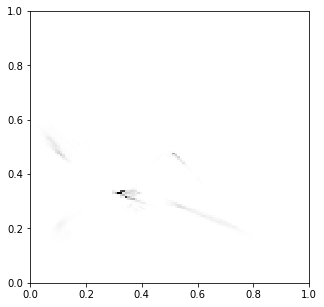

In [4]:
plt.figure(figsize=(5,5))
plt.hist2d(bags_R.flatten(), bags_G.flatten(), bins=100,cmap='binary')
plt.xlim(0,1)
plt.ylim(0,1)

From here, we would notice what color or group of colors comprises our image. To segment our image, we would need to find a reference patch and take the RG Chromaticity of that reference image. Let's consider the following green patch:

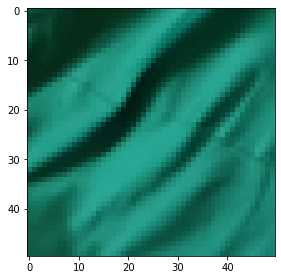

In [5]:
patch = bags[250:300,300:350,:]
imshow(patch)

Getting the RG Chromaticity of this patch:

(0.0, 1.0)

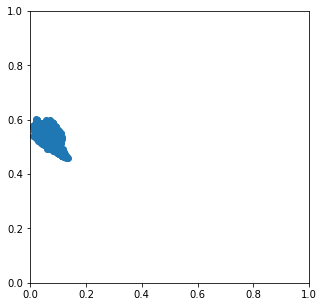

In [6]:
patch_R = patch[:,:,0]*1.0/patch.sum(axis=2)
patch_G = patch[:,:,1]*1.0/patch.sum(axis=2)

plt.figure(figsize=(5,5))
plt.scatter(patch_R.flatten(),patch_G.flatten())
plt.xlim(0,1)
plt.ylim(0,1)

(0.0, 1.0)

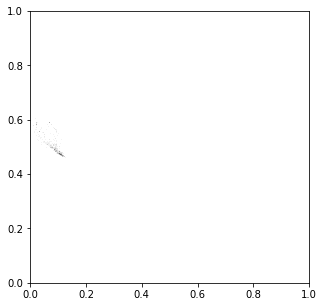

In [7]:
plt.figure(figsize=(5,5))
plt.hist2d(patch_R.flatten(), patch_G.flatten(), bins=100,cmap='binary')
plt.xlim(0,1)
plt.ylim(0,1)

**Parametric segmentation** now requires us to fit a gaussian probability distribution using this mask. This probability distribution would dictate which pixel belongs to the color of interest. To do this, we need to compute for the Mean and Standard Deviation of our object of interest.

In [8]:
std_patch_R = np.std(patch_R.flatten())
mean_patch_R = np.mean(patch_R.flatten())

std_patch_G = np.std(patch_G.flatten())
mean_patch_G = np.mean(patch_G.flatten())

Then, defining our Gaussian Function:

In [9]:
def gaussian(p,mean,std):
    return np.exp(-(p-mean)**2/(2*std**2))*(1/(std*((2*np.pi)**0.5)))

Trying this out with our computed values:

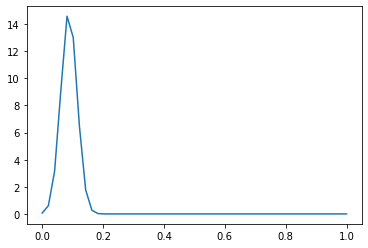

In [10]:
x = np.linspace(0,1)
y = gaussian(x,mean_patch_R,std_patch_R)
plt.plot(x,y)

We can better visualize this if we project it to our 2D chromaticity space:

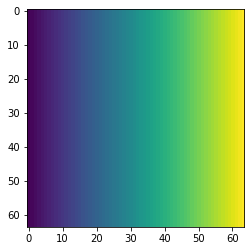

In [11]:
r_test = np.tile(np.linspace(0,1,64),(64,1))
plt.imshow(r_test)

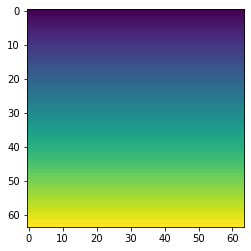

In [12]:
g_test = r_test.transpose()
plt.imshow(g_test)

/opt/conda/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


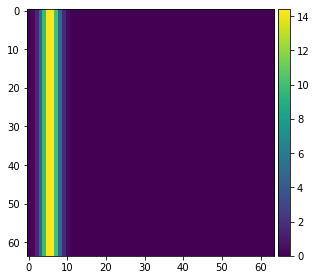

In [13]:
test_R = gaussian(r_test,mean_patch_R,std_patch_R)
imshow(test_R)

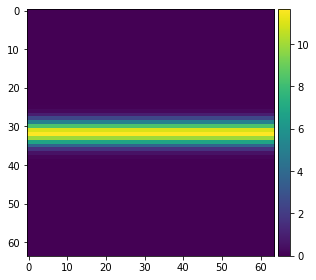

In [14]:
test_G = gaussian(g_test,mean_patch_G,std_patch_G)
imshow(test_G)

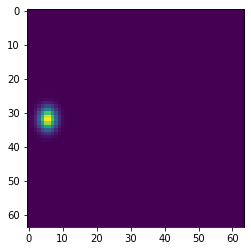

In [15]:
prob_test=test_R * test_G
plt.imshow(prob_test)

This distribution gives us the probability of a color being part of our image using the R coordinate. We can actually mask our image just by using this:

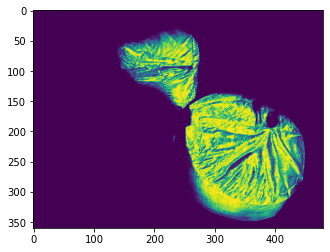

In [16]:
prob_R = gaussian(bags_R,mean_patch_R,std_patch_R)
plt.imshow(prob_R)

But this covers a *band* in our RG space. We also need to apply the G distribution.

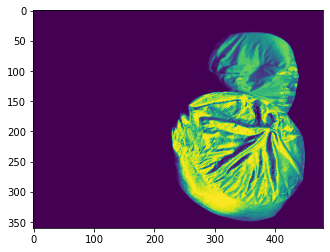

In [17]:
prob_G = gaussian(bags_G,mean_patch_G,std_patch_G)
plt.imshow(prob_G)

And since we're considering independent probabilities, we can simply multiply the masks together:

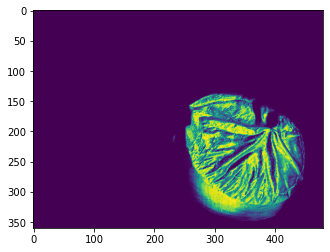

In [18]:
prob=prob_R * prob_G
plt.imshow(prob)

This now gives us the probability of the color being part of our reference patch. We can further create a mask by segmenting this image.

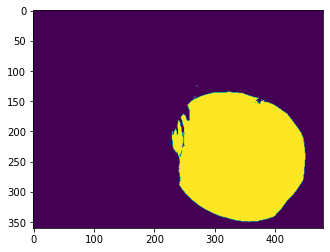

In [19]:
plt.imshow(prob>0.00000001)

#### Exercise
Apply the same method to isolate the orange beanbag.

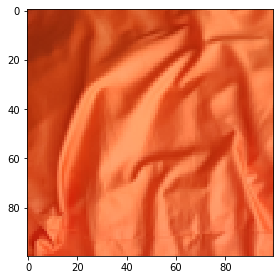

In [20]:
patch = bags[150:250,50:150,:]
imshow(patch)

(0.0, 1.0)

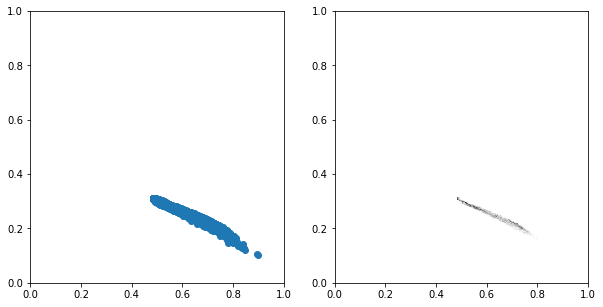

In [25]:
patch_R = patch[:,:,0]*1.0/patch.sum(axis=2)
patch_G = patch[:,:,1]*1.0/patch.sum(axis=2)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(patch_R.flatten(),patch_G.flatten())
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)

ax[1].hist2d(patch_R.flatten(), patch_G.flatten(), bins=100,cmap='binary')
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1)

In [23]:
std_patch_R = np.std(patch_R.flatten())
mean_patch_R = np.mean(patch_R.flatten())

std_patch_G = np.std(patch_G.flatten())
mean_patch_G = np.mean(patch_G.flatten())

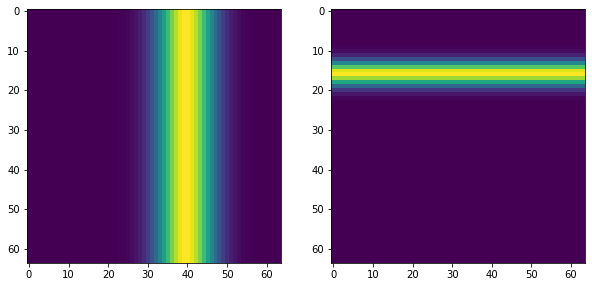

In [26]:
test_R = gaussian(r_test,mean_patch_R,std_patch_R)
test_G = gaussian(g_test,mean_patch_G,std_patch_G)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(test_R)
ax[1].imshow(test_G)

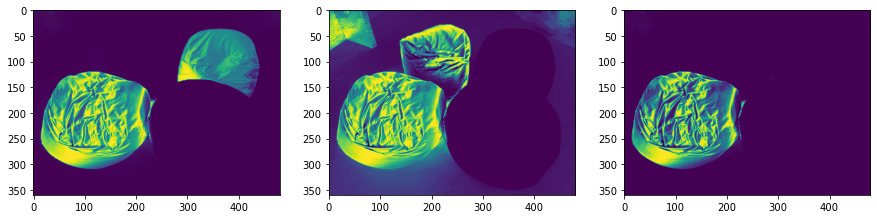

In [27]:
prob_test=test_R * test_G
prob_R = gaussian(bags_R,mean_patch_R,std_patch_R)
prob_G = gaussian(bags_G,mean_patch_G,std_patch_G)
prob=prob_R * prob_G

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(prob_R)
ax[1].imshow(prob_G)
ax[2].imshow(prob)


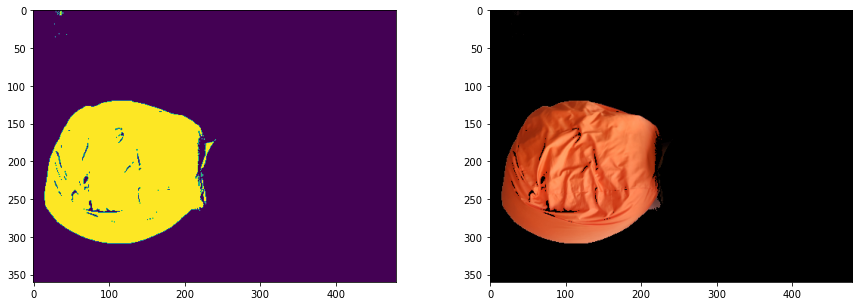

In [70]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(prob>2.5)
ax[1].imshow(bags*np.dstack([prob>2.5]*3))

## 2. Image differencing
Now, provided that instead of looking at the color, we want to know changes or movement in our videos or images. Instead of segmenting by color for our regions of interest, we can instead look at the difference of two images to find our objects.  Unless the changes in the image barely register as different colours, the differences between the images would be highlighted by the result.

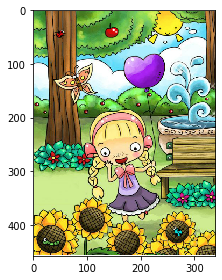

In [22]:
image1 = imread('image1.png')
imshow(image1)

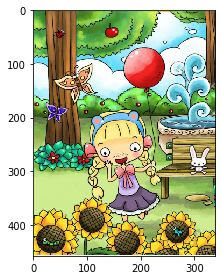

In [23]:
image2 = imread('image2.png')
imshow(image2)

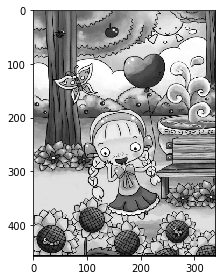

In [24]:
from skimage.color import rgb2gray

image1_gray = rgb2gray(image1)
imshow(image1_gray) 

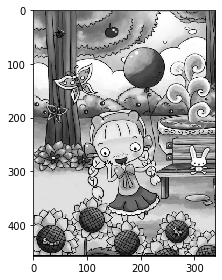

In [25]:
image2_gray = rgb2gray(image2)
imshow(image2_gray) 

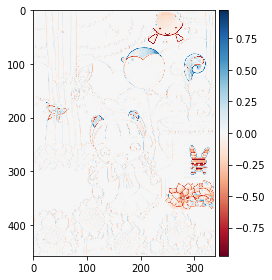

In [26]:
diff = image1_gray - image2_gray
imshow(diff)